In [1]:
import swat,pygal
from _config import container_18wk47_login, container_19wk21_login,container_xl_19wk21_login
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from matplotlib import pyplot as plt
%matplotlib inline
from plotnine import *
import os, time
%reload_ext autoreload
%autoreload 2
from dlpy import Model, Sequential
from dlpy.model import Optimizer, AdamSolver
from dlpy.layers import * 
from dlpy.splitting import two_way_split,three_way_split
from dlpy.metrics import (accuracy_score, confusion_matrix, plot_roc, 
                          plot_precision_recall, roc_auc_score, f1_score, average_precision_score)

In [2]:
#Connect to the CAS Server

host = container_xl_19wk21_login()[2]
user = container_xl_19wk21_login()[0]
pswd = container_xl_19wk21_login()[1]
sess = swat.CAS(host,5570,user,pswd)

# conn.about()

# conn = swat.CAS(login()[2],8777,login()[0],login()[1],protocol="http")
sess.setsessopt(caslib="casuser")

NOTE: 'CASUSER(sasdemo)' is now the active caslib.


+ Elapsed: 0.000697s, sys: 0.000659s, mem: 0.23mb

In [3]:
churn_df=pd.read_csv('churn.csv')
churn_df.columns = [i.replace(' ','_').replace("'",'').lower() for i in churn_df.columns]
out=sess.upload(churn_df,casout=dict(name='churn',caslib='casuser'))
#Enable SQL actions - for distributed SQL
sess.loadactionset('fedSQL')
out=out.casTable
#programmatically build query
col_list= [i for i in out.columns if i not in ('area_code','churn','intl_plan','vmail_plan')]
cas_lib='casuser'
option_params='{options replace=true}'
query = """create table {}.churn {} as select {}, 
cast(intl_plan as char) as intl_plan,
cast(vmail_plan as char) as vmail_plan,
cast(area_code as varchar) as area_code,
cast(churn as varchar) as churn
from casuser.churn """.format(cas_lib,
                              option_params,
                              col_list).replace('[','').replace(']','').replace("'",'')

#execute query and check the results
sess.fedsql.execdirect(query) # run the query
out = sess.CASTable('CHURN', caslib ='casuser') #get the results

NOTE: Cloud Analytic Services made the uploaded file available as table CHURN in caslib CASUSER(sasdemo).
NOTE: The table CHURN has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
NOTE: Added action set 'fedSQL'.
NOTE: Table CHURN was created in caslib CASUSER(sasdemo) with 3333 rows returned.


In [4]:
out.head()

,account_length,vmail_message,day_mins,eve_mins,night_mins,intl_mins,custserv_calls,day_calls,day_charge,eve_calls,...,night_calls,night_charge,intl_calls,intl_charge,state,phone,INTL_PLAN,VMAIL_PLAN,AREA_CODE,CHURN
0,128.00,25.00,265.10,197.40,244.70,10.00,1.00,110.00,45.07,99.00,...,91.00,11.01,3.00,2.70,KS,382-4657,0,1,415,0
1,107.00,26.00,161.60,195.50,254.40,13.70,1.00,123.00,27.47,103.00,...,103.00,11.45,3.00,3.70,OH,371-7191,0,1,415,0
2,137.00,0.00,243.40,121.20,162.60,12.20,0.00,114.00,41.38,110.00,...,104.00,7.32,5.00,3.29,NJ,358-1921,0,0,415,0
3,84.00,0.00,299.40,61.90,196.90,6.60,2.00,71.00,50.90,88.00,...,89.00,8.86,7.00,1.78,OH,375-9999,1,0,408,0
4,75.00,0.00,166.70,148.30,186.90,10.10,3.00,113.00,28.34,122.00,...,121.00,8.41,3.00,2.73,OK,330-6626,1,0,415,0


In [5]:
noms={'area_code','churn','intl_plan','vmail_plan'}
int_vars={'account_length', 'custserv_calls', 'day_calls', 'day_charge', 'day_mins', 'eve_calls',
          'eve_charge', 'eve_mins', 'intl_calls', 'intl_charge', 'intl_mins', 
          'night_calls','night_charge', 'night_mins', 'vmail_message', }
effect_vars={'area_code','account_length', 'custserv_calls', 'day_calls', 'day_charge', 
             'day_mins', 'eve_calls','eve_charge', 'eve_mins', 'intl_calls', 
             'intl_charge', 'intl_mins', 'intl_plan','night_calls','night_charge',
             'night_mins', 'vmail_message', 'vmail_plan'}

In [6]:
churn_df.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [7]:
train_tbl, test_tbl = two_way_split(out, test_rate=20, seed=1234, stratify=True, stratify_by='CHURN', im_table=False)

In [8]:
model1 = Sequential(sess, model_table=sess.CASTable('simple_fcnn_classifier', replace=True))
model1.add(InputLayer(std='STD'))
model1.add(Dense(30, act='relu'))
model1.add(OutputLayer(act='softmax', n=2,  error='entropy'))

NOTE: Input layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


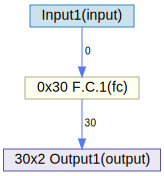

In [9]:
model1.plot_network()

In [10]:
optimizer = Optimizer(algorithm=AdamSolver(learning_rate=0.005, learning_rate_policy='step', 
                                           gamma=0.9, step_size=5), 
                      mini_batch_size=4, seed=1234, max_epochs=50, log_level=2)

result = model1.fit(train_tbl, inputs=effect_vars, nominals=noms, 
                    target='CHURN', optimizer=optimizer)

NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 752.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.02 (s).
NOTE:  The total number of threads on each worker is 24.
NOTE:  The total mini-batch size per thread on each worker is 4.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 96.
NOTE:  Target variable: CHURN
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: 0
NOTE:  Level      1: 1
NOTE:  Number of input variables:    18
NOTE:  Number of nominal input variables:      3
NOTE:  Number of numeric input variables:     15
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0         0.005          0.4652     0.2044     0.03
NOTE:  1         0.005          0.3432     0.1444     0.01
NOTE:  2         0.005          0.3029     0.1242  

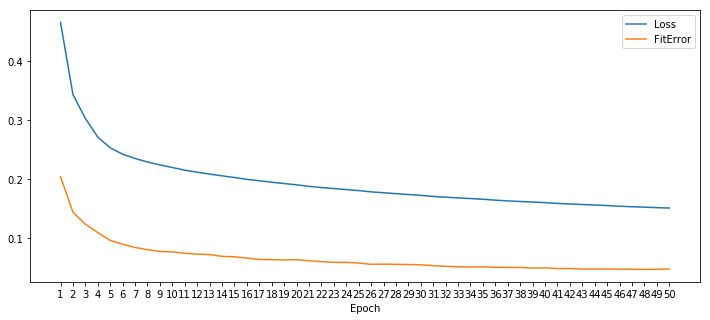

In [11]:
model1.plot_training_history()

In [12]:
test_result = model1.predict(test_tbl) # get fit stats
test_result_table = model1.valid_res_tbl # get  result table

In [13]:
# Show the confusion matrix
display(confusion_matrix(test_result_table['CHURN'], test_result_table['I_CHURN']))

I_CHURN,0,1
CHURN,,
0,556.00,14.00
1,26.00,71.00


In [15]:
auc_score = roc_auc_score(y_true='CHURN',
              y_score='P_CHURN1',
              pos_label=1,
              castable=test_result_table)
print('The AUC score is {:.3f}'.format(auc_score))

The AUC score is 0.931


In [16]:
sess.terminate()